# Pokemon GAN Training Notebook

## **Import libraries**

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import PokemonGensDataset
from WGAN import WGAN
import utils as ut
import variable as var
import os
import cuda_monitoring as cuda_mon
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
import torchvision.utils as vutils

In [3]:
cuda_mon.get_tensor_info()
cuda_mon.get_gpu_memory_info()

/home/benoit/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:144: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


total    : 7.77 GB
free     : 4.63 GB
used     : 3.14 GB	(67.93%)


## **Load DATASET**

In [4]:
resume_training = True
train_number = 2
gan_id = f"wgan_pokemon_train_{train_number}"

greyscale = False
resize_image_dim = 64
n_conv_block = 3
batch_size = 64
normalize_input = 'min_max_scale'

print(f"Greyscale: {greyscale}")
print(f"Real: {resize_image_dim}x{resize_image_dim} images")
print(f"Fake: {2**(3 + n_conv_block)}x{2**(3 + n_conv_block)} images")

Greyscale: False
Real: 64x64 images
Fake: 64x64 images


In [5]:
dset = PokemonGensDataset(greyscale=greyscale, normalize=normalize_input,
                          resize=[resize_image_dim, resize_image_dim])
dloader = DataLoader(dset, batch_size=batch_size, shuffle=True, num_workers=0)
print(f'dataset: {len(dset)} images')

dataset: 6697 images


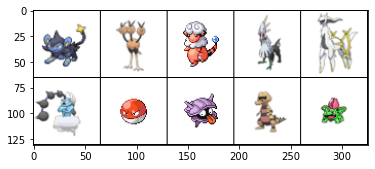

In [6]:
images, labels = next(iter(dloader))
ut.show_images_grid(images)

apply weights on inputs based on element wise auxiliary own class probability prediction
to do: in the generator loss function, multiply each sample-loss-value (torch.NLLLoss) value by its own class probability given by the discriminator. 


## **GAN Component**

In [7]:
gen_lr = 7e-5
disc_lr = 7e-5
beta1 = .5
beta2 = .999
betas = {'1': beta1, '2': beta2}
n_channel = 1 if greyscale else 3
n_feature = 32
z_dim = 100
use_inception = True

    
params = {'gen': {'n_feature': n_feature,
                  'n_channel': n_channel,
                  'lr': gen_lr,
                  'betas': betas},
          'critic': {'n_channel': n_channel,
                   'n_feature': n_feature,
                   'lr': disc_lr,
                   'betas': betas},
          'z_dim': z_dim,
          'n_conv_block': n_conv_block,
          'dataset': dset.describe(),
          'batch_size': batch_size,
          'use_inception': use_inception,
          'gradient_penalty_factor': 10,
          'stability_noise_std': 5e-2
         }

## **GAN INIT AND TRAINING**

In [8]:
gan = WGAN(params)
if os.path.exists(f'data/models/{gan_id}.pth'):
    print('RESUMING TRAINING...')
    gan.load_model(f'data/models/{gan_id}.pth')
else:
    print('NEW TRAINING...')
print(f'id: {gan_id}')

NEW TRAINING...
id: wgan_pokemon_train_2


In [9]:
gan.init_tensorboard(main_dir='runs', subdir=gan_id, port=8008)

In [108]:
gan.train(n_epoch=50, n_critic_update=2, dataloader=dloader, gan_id=gan_id)

100%|██████████| 50/50 [09:53<00:00, 11.88s/it]


## **RESULT VIZUALIZATION**

In [1]:
n = 1
with torch.no_grad():
    gan.generator.eval()
    fakes = gan.generate_fake(n, train=False)
ut.show_images_grid(fakes)

NameError: name 'torch' is not defined

In [13]:
print(gan.critic)

Critic(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=

In [14]:
fakes = gan.generate_fake(9)
x = gan.critic.main[0](fakes)
x = gan.critic.main[2][0](x)
x = gan.critic.main[2][1](x)
x = gan.critic.main[2][2](x)


In [15]:
x.shape

torch.Size([9, 512, 4, 4])

In [12]:
torch.randn(64, 32, 32, 32).view(-1, 32*32*32).shape

torch.Size([64, 32768])

In [15]:
x.shape

torch.Size([32, 64, 32, 32])

In [301]:
from matplotlib.lines import Line2D

def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    max_max_grad = 0.0
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            max_grad = p.grad.abs().max()
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(max_grad)
            max_max_grad = max_grad.item() if max_grad.item() > max_max_grad else max_max_grad
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=.1) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    print(max_grads)

[tensor(5.6651, device='cuda:0'), tensor(37.1417, device='cuda:0'), tensor(1.7497, device='cuda:0'), tensor(30.0315, device='cuda:0'), tensor(0.9447, device='cuda:0'), tensor(10.2452, device='cuda:0'), tensor(0.7397, device='cuda:0'), tensor(5.7435, device='cuda:0'), tensor(1.0466, device='cuda:0'), tensor(3.3919, device='cuda:0'), tensor(0.4834, device='cuda:0'), tensor(2.8198, device='cuda:0'), tensor(0.4163, device='cuda:0'), tensor(4.1677, device='cuda:0'), tensor(0.4484, device='cuda:0'), tensor(1.1201, device='cuda:0'), tensor(0.2270, device='cuda:0'), tensor(1.3180, device='cuda:0'), tensor(0.2039, device='cuda:0'), tensor(3.9053, device='cuda:0'), tensor(0.7421, device='cuda:0'), tensor(0.1336, device='cuda:0'), tensor(0.7735, device='cuda:0'), tensor(0.3978, device='cuda:0'), tensor(4.6653, device='cuda:0'), tensor(0.7022, device='cuda:0'), tensor(0.1534, device='cuda:0'), tensor(0.6080, device='cuda:0'), tensor(0.2281, device='cuda:0'), tensor(1.1207, device='cuda:0'), tensor

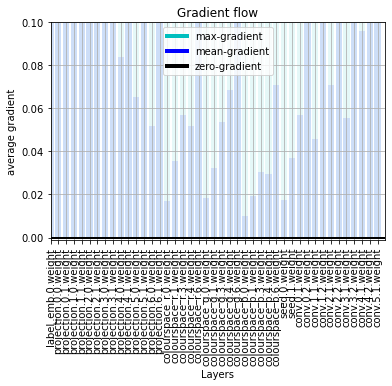

In [302]:
plot_grad_flow(gan.generator.named_parameters())

In [144]:
torch.mul(torch.randn((16, 100)).view(16, 100, 1, 1), torch.randn((16, 100, 1, 1))).shape

torch.Size([16, 100, 1, 1])

In [125]:
fake, fake_classes = gan.generate_fake(batch_size)

fake_adv, fake_aux = gan.discriminator(fake)
torch.gather(fake_aux, 1, fake_classes.unsqueeze(1)).shape

torch.Size([128, 1])

In [126]:
fake_aux.shape

torch.Size([128, 10])

In [127]:
fake_classes.unsqueeze(1).shape

torch.Size([128, 1])

In [49]:
gan.generator.label_emb(torch.randint(10, (128, 1), device=var.device)).shape

torch.Size([128, 1, 100])

In [37]:
25*180/12

375.0